In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import cartopy as cart
import cartopy.crs as ccrs
import cmocean.cm as cmo
import seaborn as sns
from glob import glob
import cartopy.feature as cfeature
import pandas as pd

from scipy import stats
import matplotlib.cm as cm
import matplotlib

In [2]:
sim = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/set_15/set15_500.zarr/')
sim = sim.compute()

## Filter function

In [3]:
aux = np.diff(sim['lon'], axis=1)

In [4]:
_, l = np.where(aux == 0)

In [5]:
aux = np.sort(l)

In [6]:
aux[-1]

3649

In [7]:
def filter_trajectories(data, condition, last_index=False):
    k, _ = np.where(condition)
    index = np.unique(k)
    
    data_relevant = data.where(data['trajectory'].isin(index), drop=True)

    return data_relevant

## Continental shelf

In [8]:
shelf = filter_trajectories(sim, sim['seafloor'] < 200, last_index=True)

In [9]:
shelf

<xarray.Dataset>
Dimensions:           (traj: 8, obs: 3651)
Dimensions without coordinates: traj, obs
Data variables: (12/18)
    Kz                (traj, obs) float32 1.482e-05 1.461e-05 ... 0.002565
    abs_salinity      (traj, obs) float32 34.74 34.74 34.74 ... 34.71 34.78
    cons_temperature  (traj, obs) float32 0.7251 0.7317 0.74 ... 13.75 14.03
    density           (traj, obs) float32 1.028e+03 1.028e+03 ... 1.026e+03
    diameter          (traj, obs) float64 5.062e-08 5.062e-08 ... 2.578e-05
    lat               (traj, obs) float64 -32.17 -32.14 -32.11 ... -39.68 -39.68
    ...                ...
    trajectory        (traj, obs) float64 767.0 767.0 ... 9.107e+03 9.107e+03
    u                 (traj, obs) float32 -4.648e-07 -4.327e-07 ... 1.453e-06
    v                 (traj, obs) float32 -1.376e-07 -3.786e-07 ... 1.397e-06
    v_s               (traj, obs) float32 0.0 4.779e-10 4.779e-10 ... 0.0 0.0
    w                 (traj, obs) float32 -0.000245 -0.0001239 ... -5.463e-05
    z                 (traj, obs) float64 5e+03 5.012e+03 ... 10.35 10.35
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.3.0-303-gd31c5f32

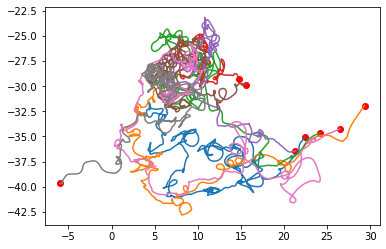

In [10]:
for t in range(shelf.dims['traj']):
    plt.plot(shelf['lon'][t,:], shelf['lat'][t,:])
    plt.scatter(shelf['lon'][t,-1], shelf['lat'][t,-1], c='red')

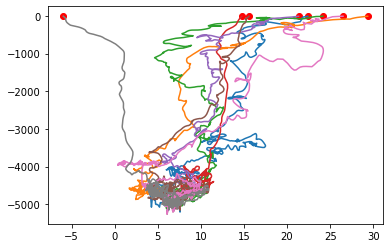

In [11]:
for t in range(shelf.dims['traj']):
    plt.plot(shelf['lon'][t,:], -shelf['z'][t,:])
    plt.scatter(shelf['lon'][t,-1], -shelf['z'][t,-1], c='red')

In [12]:
shp_dict = {}
files = glob('../data/ne_10m_bathymetry_all/*.shp')
assert len(files) > 0
files.sort()
for f in files:
    depth = f.split('_')[-1].split('.')[0]
    # depth = '-' + f.split('_')[-1].split('.')[0]
    # depths.append(depth)
    nei = cart.io.shapereader.Reader(f)
    shp_dict[depth] = nei

depths = [d for d in shp_dict.keys()][::-1]
colors = sns.mpl_palette('cmo.ice_r',n_colors=8)
cmap   = sns.mpl_palette('cmo.ice',n_colors=8,as_cmap=True)

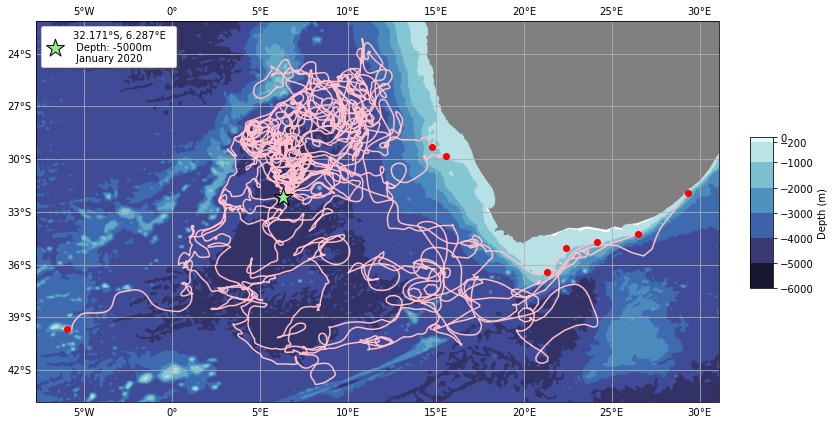

In [13]:
max_depth = -5500
min_depth = 0 

fig = plt.figure(figsize=(13,7))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent((-5, 20, -40, -25), crs=ccrs.PlateCarree())


i = 0
for depth in depths[:8]:
    ax.add_geometries(shp_dict[depth].geometries(),crs=ccrs.PlateCarree(),color=colors[i])
    i+=1

ax.add_feature(cart.feature.NaturalEarthFeature(category='physical',name='land',scale='110m'),color='grey',
              zorder=0)

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False

# Add custom colorbar
axi = fig.add_axes([0.910,0.35,0.025,0.3])
# axi = fig.add_axes([0.8,0.2,0.025,0.6])
norm = matplotlib.colors.Normalize(vmin=-6000,vmax=0)
cbar = matplotlib.colorbar.ColorbarBase(ax=axi,cmap=cmap,norm=norm,
        boundaries=(-np.array(depths[:8]).astype(int)).tolist()[::-1],
        ticks=-np.array(depths).astype(int),
        spacing='proportional',
        extend='neither',
        label='Depth (m)'
        )

ax.scatter(6.287, -32.171, marker='*',
           zorder=5, color='lightgreen', 
           label='32.171°S, 6.287°E  \n Depth: -5000m \n January 2020', 
           s=350,
          edgecolors='black')

ax.legend(loc='upper left', shadow=True, fontsize=10)
    
# frame = -1
# ax.plot(sim['lon'][8372,:], sim['lat'][8372,:], zorder=4, c='yellow')
# ax.scatter(shelf['lon'][:,:], shelf['lat'][:,:], zorder=5, c='red')
# ax.scatter(sim['lon'][8372,-10], sim['lat'][8372,-10], zorder=5, c='red')

for t in range(shelf.dims['traj']):
    ax.plot(shelf['lon'][t,:], shelf['lat'][t,:], c='pink')
    ax.scatter(shelf['lon'][t,-1], shelf['lat'][t,-1], c='red', zorder=5)

# bar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.03])
# fig.colorbar(im, cax=bar_ax, orientation='horizontal', label='Particle diameter (m)')
# ax.set_title('10 years before sampling', fontsize=15, weight='bold')
# plt.savefig('../figs/revers.png')

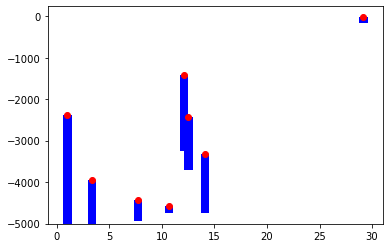

In [14]:
frame= 1700


plt.bar(shelf['lon'][:,frame], shelf['seafloor'][:,frame]-shelf['z'][:,frame] ,bottom=-shelf['seafloor'][:,frame], color='blue')
plt.scatter(shelf['lon'][:,frame], -shelf['z'][:,frame], color='red', zorder=4)

/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1546: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = matplotlib.axes.Axes.scatter(self, *args, **kwargs)


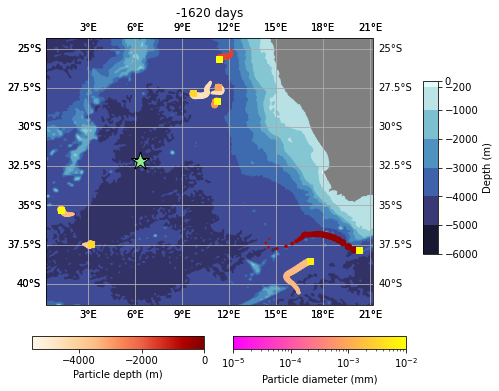

In [88]:
max_depth = -6000
min_depth = 0 

fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(2, 2,  width_ratios=(8, 2), height_ratios=(8, 2),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.07, hspace=0.07)

ax = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5)

i = 0
for depth in depths[:8]:
    ax.add_geometries(shp_dict[depth].geometries(),crs=ccrs.PlateCarree(),color=colors[i])
    i+=1

ax.add_feature(cart.feature.NaturalEarthFeature(category='physical',name='land',scale='110m'),color='grey',
              zorder=0)

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False

# Add custom colorbar
axi = fig.add_axes([0.78,0.4,0.025,0.4])
# axi = fig.add_axes([0.8,0.2,0.025,0.6])
norm = matplotlib.colors.Normalize(vmin=-6000,vmax=0)
cbar = matplotlib.colorbar.ColorbarBase(ax=axi,cmap=cmap,norm=norm,
        boundaries=(-np.array(depths[:8]).astype(int)).tolist()[::-1],
        ticks=-np.array(depths).astype(int),
        spacing='proportional',
        extend='neither',
        label='Depth (m)'
        )

ax.scatter(6.287, -32.171, marker='*',
           zorder=5, color='lightgreen', 
           label='32.171°S, 6.287°E  \n Depth: -5000m \n January 2020', 
           s=350, edgecolors='black')

# {shelf['time'][0, frame].values}
ax.set_title(f'-{frame} days')

frame = 1620
window = 30
if frame - window < 0:
    shadow = 0
    trail = frame
    
else:
    shadow = frame - window
    trail = window
    

im = ax.scatter(shelf['lon'][:,shadow:frame].T, shelf['lat'][:,shadow:frame].T, 
           c=-shelf['z'][:,shadow:frame].T, zorder=5, s=np.array([np.linspace(1, 41, trail)]*8).T, 
                cmap='OrRd',
               vmax=0, vmin=-5500)

im2 = ax.scatter(shelf['lon'][:,frame], shelf['lat'][:,frame], 
                c=shelf['diameter'][:,frame]*1000, 
                zorder=5, cmap='spring', norm=matplotlib.colors.LogNorm(),
               vmax=1e-2, vmin=1e-5, marker='s')

bar_ax = fig.add_axes([0.1, 0.18, 0.3, 0.03])
fig.colorbar(im, cax=bar_ax, orientation='horizontal', label='Particle depth (m)')

bar_ax2 = fig.add_axes([0.45, 0.18, 0.3, 0.03])
fig.colorbar(im2, cax=bar_ax2, orientation='horizontal', label='Particle diameter (mm)')
# ax.set_title('10 years before sampling', fontsize=15, weight='bold')
plt.savefig('../figs/snapzhotz.png')

### Nanoparticles

In [16]:
nano = sim.where(sim.diameter < 1e-6, drop=True)

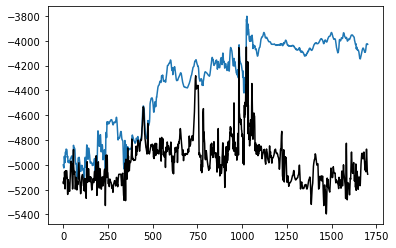

In [31]:
p=1001
plt.plot(-nano['z'][p,:])
plt.plot(-nano['seafloor'][p,:], c='k')

[]

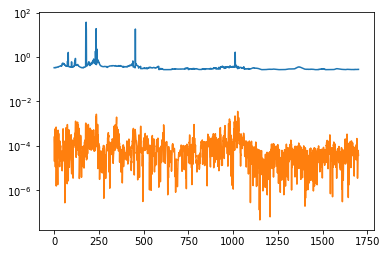

In [37]:
plt.plot(np.sqrt(2*nano['Kz'][p, :])*60)
plt.plot(abs(nano['w'][p, :]))
# plt.plot(nano['Kz'][p+10, :])

plt.semilogy()

[]

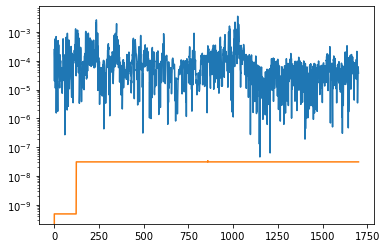

In [33]:

plt.plot(abs(nano['w'][p, :]))
plt.plot(abs(nano['v_s'][p, :]))

plt.semilogy()

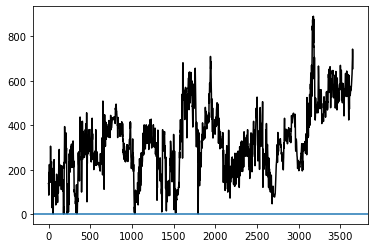

In [18]:
plt.plot(nano['seafloor'][1000,:] - nano['z'][1000,:], c='k')
plt.axhline(0)

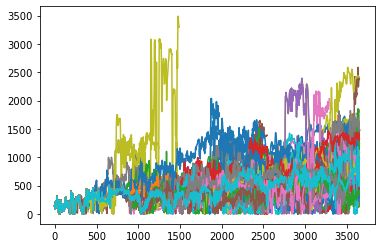

In [19]:
for i in range(0, 100, 1):
    plt.plot(nano['seafloor'][i,:] - nano['z'][i,:])

# plt.axhline(1e-3, color='black', linestyle='--')
# plt.semilogy()
# plt.xlim(-10,10)

In [92]:
bins =  np.linspace(-5200, 0, 53)

In [34]:
time = np.linspace(0, 3650, 3651)

In [97]:
statz = {}
counts = {}

for ft in [500, 2500, 5000]:
    print(ft)
    sim = xr.open_zarr(f'/storage/shared/oceanparcels/output_data/data_Claudio/set_15/set15_{ft}.zarr')
# sim = sim.compute()
    nano = sim.where(sim.diameter < 1e-6, drop=True)
    hist_counts = np.zeros((52, 3651))

    for i, fr in enumerate(range(0, 3651, 1)):
    #     print(i)

        x = plt.hist(-nano['z'][:,fr], bins=bins, label = fr, density=False)
        hist_counts[:, i] = x[0]

    plt.close()

    total_particles = np.sum(hist_counts, axis=0)
    statz[ft] = hist_counts
    counts[ft] = total_particles
    
# plt.legend()
# plt.xlim(-5200, -3000)

500
2500
5000


In [23]:
a = np.ma.masked_equal(statz[500], 0)

In [35]:
statz[500].shape

(52, 3651)

In [36]:
bins

array([-5200., -5100., -5000., -4900., -4800., -4700., -4600., -4500.,
       -4400., -4300., -4200., -4100., -4000., -3900., -3800., -3700.,
       -3600., -3500., -3400., -3300., -3200., -3100., -3000., -2900.,
       -2800., -2700., -2600., -2500., -2400., -2300., -2200., -2100.,
       -2000., -1900., -1800., -1700., -1600., -1500., -1400., -1300.,
       -1200., -1100., -1000.,  -900.,  -800.,  -700.,  -600.,  -500.,
        -400.,  -300.,  -200.,  -100.,     0.])

/tmp/ipykernel_209784/3930218328.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax[1].pcolormesh(x, y, a/counts[500], cmap='jet')
/tmp/ipykernel_209784/3930218328.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2= ax[2].pcolormesh(x, y, b/counts[2500], cmap='jet')
/tmp/ipykernel_209784/3930218328.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corne

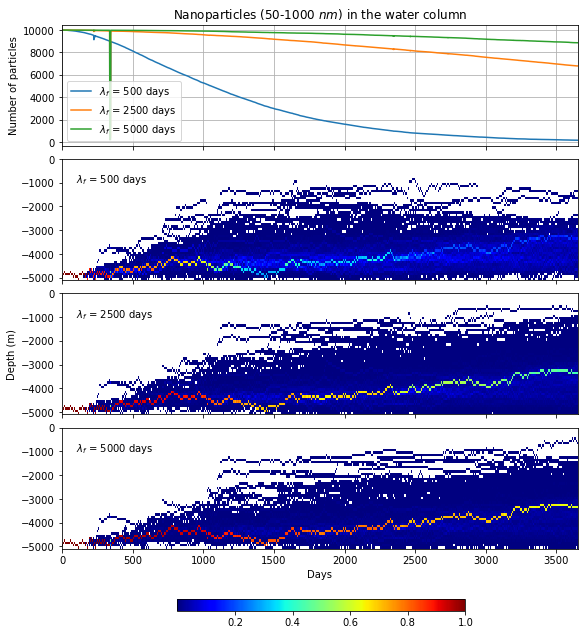

In [98]:
x, y = np.meshgrid(time, bins[1:])

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(8, 8),
                       sharex=True, constrained_layout=True)

for ft in [500, 2500, 5000]:
    ax[0].plot(time, counts[ft],label=f'$\lambda_f$ = {ft} days')
    ax[0].legend()
    

ax[0].set_ylabel('Number of particles')
# ax[1].set_ylabel('Number of particles')  
ax[2].set_ylabel('Depth (m)')  
ax[3].set_xlabel('Days') 

ax[0].grid()

# plt.text()
a = np.ma.masked_equal(statz[500], 0)
im1 = ax[1].pcolormesh(x, y, a/counts[500], cmap='jet')
ax[1].text(100, -1000, '$\lambda_f$ = 500 days')

b = np.ma.masked_equal(statz[2500], 0)
im2= ax[2].pcolormesh(x, y, b/counts[2500], cmap='jet')
ax[2].text(100, -1000, '$\lambda_f$ = 2500 days')


c = np.ma.masked_equal(statz[5000], 0)
im3 = ax[3].pcolormesh(x, y, c/counts[5000], cmap='jet')
ax[3].text(100, -1000, '$\lambda_f$ = 5000 days')


bar_ax = fig.add_axes([0.3, -0.05, 0.5, 0.02])

cbar = fig.colorbar(im3, cax=bar_ax, orientation='horizontal')
# ax[0].pcolormesh(x, y, -hist_counts, cmap='viridis')
ax[0].set_title('Nanoparticles (50-1000 $nm$) in the water column')
plt.savefig('../figs/frag_t_Vdist_nano.png', dpi=300)

0 5000
1 2500
2 500


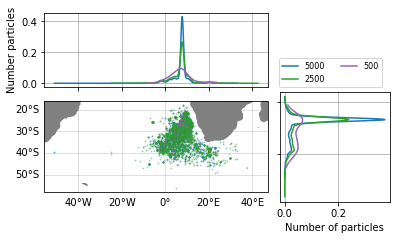

In [38]:
frame = 0
n_day = 360

fig = plt.figure()
gs = fig.add_gridspec(3, 2,  width_ratios=(6.1, 3), height_ratios=(2, 3, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.07, hspace=0.07)

ax = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
# ax.set_extent((-45, 46, -52, -16))
ax.add_feature(cfeature.LAND,facecolor='#808080', zorder=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5)
gl.right_labels = False
gl.top_labels = False

ax_lon = plt.subplot(gs[0, 0], sharex=ax)
ax_lon.grid()
ax_lon.set_xticklabels([])
ax_lon.set_ylabel('Number particles')
# ax_lon.set_ylim(-5000, 0)

ax_lat = plt.subplot(gs[1, 1], sharey=ax)
ax_lat.grid()
ax_lat.set_yticklabels([])
ax_lat.set_xlabel('Number of particles')


ax_void = plt.subplot(gs[0, 1], sharey=ax)
ax_void.axis('off')


size_point = 0.7
frame = -1

frag_times = [5000, 2500, 500]

colormap='tab10'
x_colors = np.linspace(0, 0.4, len(frag_times))
colors = cm.get_cmap(colormap)(x_colors)

for i, ft in enumerate(frag_times):
    print(i, ft)
    sim = xr.open_zarr(f'/storage/shared/oceanparcels/output_data/data_Claudio/set_15/set15_{ft}.zarr/')
    suf = sim.where(sim.diameter < 1e-6, drop=True)
    
    xmin = suf['lon'][:,-1].dropna(dim='traj').min().values
    xmax = suf['lon'][:,-1].dropna(dim='traj').max().values
    ymin = suf['lat'][:,-1].dropna(dim='traj').min().values
    ymax = suf['lat'][:,-1].dropna(dim='traj').max().values
    x_range = np.linspace(xmin, xmax, 500)
    y_range = np.linspace(ymin, ymax, 500)
    
    kernel_lon = stats.gaussian_kde(suf['lon'][:,-1].dropna(dim='traj'))
    kernel_lat = stats.gaussian_kde(suf['lat'][:,-1].dropna(dim='traj'))
    
    kde_lon = kernel_lon(x_range)
    kde_lat = kernel_lat(y_range)
    
    n_surf_part = suf['lon'][:,-1].dropna(dim='traj').shape[0]
    
    ax.scatter(suf['lon'][:,frame], suf['lat'][:,frame], color=colors[i], zorder=4, s=1, alpha=0.3)

    ax_lon.plot(x_range, kde_lon, color=colors[i], label=ft)
    ax_lat.plot(kde_lat, y_range, color=colors[i])
    
ax_lon.legend(loc=(1.05, 0.), ncol=2, fontsize=8)

plt.savefig('../figs/frag_t_Hdist_nano.png', dpi=300)

## all particles

In [94]:
statz_all = {}
counts_all = {}

for ft in [500, 2500, 5000]:
    print(ft)
    sim = xr.open_zarr(f'/storage/shared/oceanparcels/output_data/data_Claudio/set_15/set15_{ft}.zarr')
# sim = sim.compute()
#     nano = sim.where(sim.diameter < 1e-6, drop=True)
    hist_counts = np.zeros((52, 3651))

    for i, fr in enumerate(range(0, 3651, 1)):
    #     print(i)

        x = plt.hist(-sim['z'][:,fr], bins=bins, label = fr, density=False)
        hist_counts[:, i] = x[0]

    plt.close()

    total_particles = np.sum(hist_counts, axis=0)
    statz_all[ft] = hist_counts
    counts_all[ft] = total_particles
    
# plt.legend()
# plt.xlim(-5200, -3000) all particles

500
2500
5000


In [90]:
time = np.linspace(0, 3650, 3651)

/tmp/ipykernel_209784/3803715408.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax[1].pcolormesh(x, y, a/counts_all[500], cmap='jet')
/tmp/ipykernel_209784/3803715408.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2= ax[2].pcolormesh(x, y, b/counts_all[2500], cmap='jet')
/tmp/ipykernel_209784/3803715408.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify t

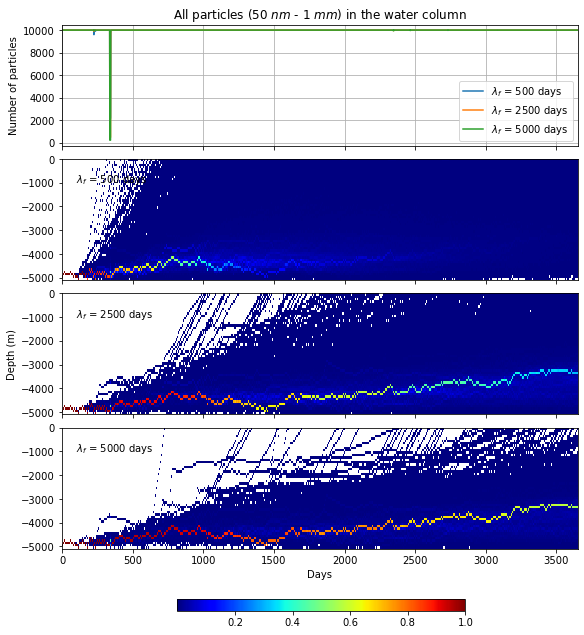

In [96]:
x, y = np.meshgrid(time, bins[1:])

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(8, 8),
                       sharex=True, constrained_layout=True)

for ft in [500, 2500, 5000]:
    ax[0].plot(time, counts_all[ft],label=f'$\lambda_f$ = {ft} days')
    ax[0].legend()
    

ax[0].set_ylabel('Number of particles')
# ax[1].set_ylabel('Number of particles')  
ax[2].set_ylabel('Depth (m)')  
ax[3].set_xlabel('Days') 

ax[0].grid()

# plt.text()
a = np.ma.masked_equal(statz_all[500], 0)
im1 = ax[1].pcolormesh(x, y, a/counts_all[500], cmap='jet')
ax[1].text(100, -1000, '$\lambda_f$ = 500 days')

b = np.ma.masked_equal(statz_all[2500], 0)
im2= ax[2].pcolormesh(x, y, b/counts_all[2500], cmap='jet')
ax[2].text(100, -1000, '$\lambda_f$ = 2500 days')


c = np.ma.masked_equal(statz_all[5000], 0)
im3 = ax[3].pcolormesh(x, y, c/counts_all[5000], cmap='jet')
ax[3].text(100, -1000, '$\lambda_f$ = 5000 days')


bar_ax = fig.add_axes([0.3, -0.05, 0.5, 0.02])

cbar = fig.colorbar(im3, cax=bar_ax, orientation='horizontal')
# ax[0].pcolormesh(x, y, -hist_counts_all, cmap='viridis')
ax[0].set_title('All particles (50 $nm$ - 1 $mm$) in the water column')
plt.savefig('../figs/frag_t_Vdist_all.png', dpi=300)

0 5000


ValueError: zero-size array to reduction operation fmin which has no identity

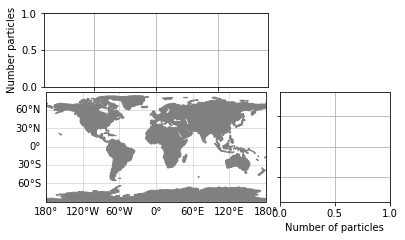

In [234]:
frame = 0
n_day = 360

fig = plt.figure()
gs = fig.add_gridspec(3, 2,  width_ratios=(6.1, 3), height_ratios=(2, 3, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.07, hspace=0.07)

ax = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
# ax.set_extent((-45, 46, -52, -16))
ax.add_feature(cfeature.LAND,facecolor='#808080', zorder=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5)
gl.right_labels = False
gl.top_labels = False

ax_lon = plt.subplot(gs[0, 0], sharex=ax)
ax_lon.grid()
ax_lon.set_xticklabels([])
ax_lon.set_ylabel('Number particles')
# ax_lon.set_ylim(-5000, 0)

ax_lat = plt.subplot(gs[1, 1], sharey=ax)
ax_lat.grid()
ax_lat.set_yticklabels([])
ax_lat.set_xlabel('Number of particles')


ax_void = plt.subplot(gs[0, 1], sharey=ax)
ax_void.axis('off')


size_point = 0.7
frame = -1

frag_times = [5000, 2500, 500]

colormap='tab10'
x_colors = np.linspace(0, 0.4, len(frag_times))
colors = cm.get_cmap(colormap)(x_colors)

for i, ft in enumerate(frag_times):
    print(i, ft)
    suf = xr.open_zarr(f'/storage/shared/oceanparcels/output_data/data_Claudio/set_15/set15_{ft}.zarr/')
#     suf = sim.where(sim.diameter < 1e-6, drop=True)
    
    xmin = suf['lon'][:,-1].dropna(dim='traj').min().values
    xmax = suf['lon'][:,-1].dropna(dim='traj').max().values
    ymin = suf['lat'][:,-1].dropna(dim='traj').min().values
    ymax = suf['lat'][:,-1].dropna(dim='traj').max().values
    x_range = np.linspace(xmin, xmax, 500)
    y_range = np.linspace(ymin, ymax, 500)
    
    kernel_lon = stats.gaussian_kde(suf['lon'][:,-1].dropna(dim='traj'))
    kernel_lat = stats.gaussian_kde(suf['lat'][:,-1].dropna(dim='traj'))
    
    kde_lon = kernel_lon(x_range)
    kde_lat = kernel_lat(y_range)
    
    n_surf_part = suf['lon'][:,-1].dropna(dim='traj').shape[0]
    
    ax.scatter(suf['lon'][:,frame], suf['lat'][:,frame], color=colors[i], zorder=4, s=2, alpha=0.6)

    ax_lon.plot(x_range, kde_lon, color=colors[i], label=ft)
    ax_lat.plot(kde_lat, y_range, color=colors[i])
    
ax_lon.legend(loc=(1.05, 0.), ncol=2, fontsize=8)

# plt.savefig('../figs/frag_t_Hdist_nano.png', dpi=300)